<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%9D%D0%A1_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Домашнее задание и загрузка библиотек



Используйте готовый ноутбук с занятия.

1. Соберите обучающую и проверочную выборку (просто запуская последовательно ячейки ноутбука).

2. Обучите полносвязную сеть.

3. Сделайте совсем простую сеть: один скрытый слой и 10 нейронов.

4. Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.

5. Добавьте в сеть слои Dropout.

6. Добавьте в сеть слои BatchNormalization.

7. Поменяйте внутренние активационные функции, варианты: relu, elu, linear.

8. Поменяйте размер batch_size: маленький, средний и большой.

Во всех пунктах, где запускали сеть (пункты 2-8), напишите, какую использовали архитектуру, какая была точность на обучающей и проверочной выборках.

Напишите свои выводы.

In [ ]:
import os
import librosa
from librosa.feature.spectral import chroma_stft
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузка и обработка музыкальных данных

In [ ]:
!unzip -q '/content/drive/MyDrive/БАЗЫ/genres.zip'

In [ ]:
genres = os.listdir('genres')

In [ ]:
!ls genres/metal #смотрю что в папке metal

metal.00000.au	metal.00020.au	metal.00040.au	metal.00060.au	metal.00080.au
metal.00001.au	metal.00021.au	metal.00041.au	metal.00061.au	metal.00081.au
metal.00002.au	metal.00022.au	metal.00042.au	metal.00062.au	metal.00082.au
metal.00003.au	metal.00023.au	metal.00043.au	metal.00063.au	metal.00083.au
metal.00004.au	metal.00024.au	metal.00044.au	metal.00064.au	metal.00084.au
metal.00005.au	metal.00025.au	metal.00045.au	metal.00065.au	metal.00085.au
metal.00006.au	metal.00026.au	metal.00046.au	metal.00066.au	metal.00086.au
metal.00007.au	metal.00027.au	metal.00047.au	metal.00067.au	metal.00087.au
metal.00008.au	metal.00028.au	metal.00048.au	metal.00068.au	metal.00088.au
metal.00009.au	metal.00029.au	metal.00049.au	metal.00069.au	metal.00089.au
metal.00010.au	metal.00030.au	metal.00050.au	metal.00070.au	metal.00090.au
metal.00011.au	metal.00031.au	metal.00051.au	metal.00071.au	metal.00091.au
metal.00012.au	metal.00032.au	metal.00052.au	metal.00072.au	metal.00092.au
metal.00013.au	metal.0003

In [ ]:
def get_features(y,sr): # параметризация сигналов аудио
  chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)# цветность 
  mfcc = librosa.feature.mfcc(y = y, sr = sr) # центр тяжести

  rmse = np.mean(librosa.feature.rms(y = y))# амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y = y, sr = sr))#ср.спектрального центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y = y, sr = sr))# cр. ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y = y, sr = sr))# ср. спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))# ср. частота пересечения нуля
  
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  for e in mfcc:
    out.append(np.mean(e))
  for e in chroma_stft:
    out.append(np.mean(e))
  return out

In [ ]:
X_train = []
Y_train = []
curr_time = time.time()

for i in range(len(genres)):
  g = genres[i] # опять цикл уффф
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, duration=30) #  mono не пишу и так стоит по умолчанию
    out = get_features(y, sr)
    X_train.append(out)
    Y_train.append(to_categorical(i, len(genres)))
  print('Жанр ', g, ' готов к сдаче ГТО: ', round(time.time() - curr_time), 'c', sep='')
  curr_time = time.time()
X_train = np.array(X_train)
Y_train = np.array(Y_train)  

Жанр blues готов к сдаче ГТО: 41c
Жанр disco готов к сдаче ГТО: 40c
Жанр reggae готов к сдаче ГТО: 40c
Жанр country готов к сдаче ГТО: 40c
Жанр hiphop готов к сдаче ГТО: 40c
Жанр rock готов к сдаче ГТО: 40c
Жанр jazz готов к сдаче ГТО: 40c
Жанр pop готов к сдаче ГТО: 40c
Жанр metal готов к сдаче ГТО: 41c
Жанр classical готов к сдаче ГТО: 41c


In [ ]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)




---
нормируем:


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
print(X_train[11])

[-0.44060949 -1.38573472 -1.41564913 -1.30217509 -1.22339734 -0.82632308
  1.22013953 -0.25726196  1.63661597  0.55444341 -0.22581498  0.70806887
 -1.14741438 -0.07407722 -1.28571158  0.46026337 -2.07097356 -0.99219338
  0.35707899  1.6440644  -0.23051831  0.21865027 -0.48724277  2.63188008
 -0.50516815 -1.56583444 -0.72683775 -1.68430708 -1.39911188  0.79220662
 -1.32483885 -2.05314303 -1.97970238 -0.81458197  2.12141127 -0.08619241
 -1.58059586]


выборки:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)
print(y_train.shape)

(900, 37)
(100,)
(100, 37)
(900,)


# Совсем простая НС: один скрытый и 10 на выходе.

In [ ]:
indexes = range(0, 37)

In [ ]:
model = Sequential()
model.add(Dense(256, activation='elu', input_shape = (len(indexes),)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adadelta(learning_rate=0.1), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               9728      
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 12,298
Trainable params: 12,298
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train[:, indexes], y_train, epochs=500, batch_size=20, validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
45/45 [==============================] - 2s 7ms/step - loss: 2.2291 - accuracy: 0.1644 - val_loss: 1.9303 - val_accuracy: 0.3600
Epoch 2/500
45/45 [==============================] - 0s 3ms/step - loss: 1.9149 - accuracy: 0.3244 - val_loss: 1.6908 - val_accuracy: 0.4400
Epoch 3/500
45/45 [==============================] - 0s 3ms/step - loss: 1.7617 - accuracy: 0.3678 - val_loss: 1.5689 - val_accuracy: 0.4600
Epoch 4/500
45/45 [==============================] - 0s 3ms/step - loss: 1.6659 - accuracy: 0.3889 - val_loss: 1.4980 - val_accuracy: 0.4700
Epoch 5/500
45/45 [==============================] - 0s 3ms/step - loss: 1.5961 - accuracy: 0.4089 - val_loss: 1.4447 - val_accuracy: 0.4700
Epoch 6/500
45/45 [==============================] - 0s 3ms/step - loss: 1.5396 - accuracy: 0.4333 - val_loss: 1.4053 - val_accuracy: 0.4700
Epoch 7/500
45/45 [==============================] - 0s 3ms/step - loss: 1.4924 - accuracy: 0.4533 - val_loss: 1.3710 - val_accuracy: 0.4700
Epoch 8/500
4

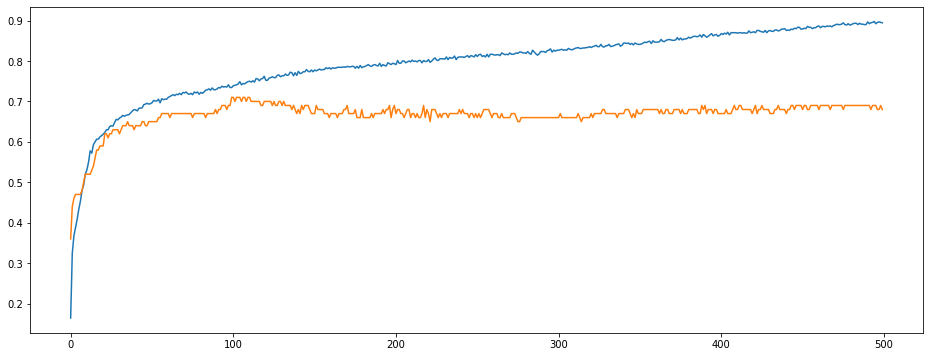

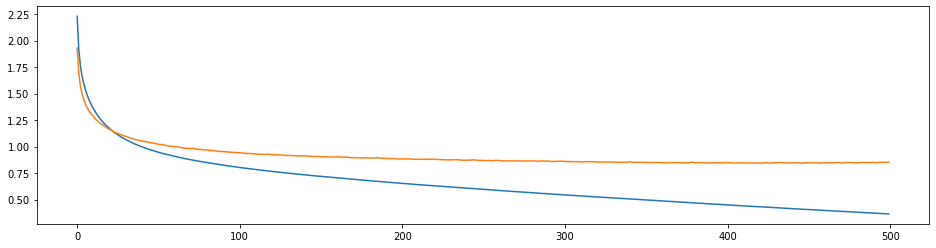

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
plt.figure(figsize=(16,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# сложная сеть: 5-7 слоёв по 100-1000 нейронов.

In [ ]:
modelSE = Sequential()
modelSE.add(Dense(1024, activation='elu', input_shape = (len(indexes),)))
modelSE.add(Dense(512, activation='elu'))
modelSE.add(Dense(256, activation='elu'))
modelSE.add(Dense(128, activation='elu'))
modelSE.add(Dense(64, activation='elu'))
modelSE.add(Dense(128, activation='linear'))
modelSE.add(Dense(10, activation='softmax'))

In [ ]:
modelSE.compile(optimizer=Adadelta(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelSE.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              38912     
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 10)               

In [ ]:
historySE = modelSE.fit(X_train[:, indexes], y_train, epochs=500, batch_size=20, validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
45/45 [==============================] - 1s 8ms/step - loss: 1.7044 - accuracy: 0.3933 - val_loss: 1.3267 - val_accuracy: 0.5500
Epoch 2/500
45/45 [==============================] - 0s 4ms/step - loss: 1.3203 - accuracy: 0.5567 - val_loss: 1.1532 - val_accuracy: 0.6000
Epoch 3/500
45/45 [==============================] - 0s 4ms/step - loss: 1.1541 - accuracy: 0.6256 - val_loss: 1.1411 - val_accuracy: 0.6400
Epoch 4/500
45/45 [==============================] - 0s 6ms/step - loss: 1.0627 - accuracy: 0.6356 - val_loss: 1.0674 - val_accuracy: 0.6200
Epoch 5/500
45/45 [==============================] - 0s 6ms/step - loss: 0.9815 - accuracy: 0.6744 - val_loss: 1.1452 - val_accuracy: 0.6200
Epoch 6/500
45/45 [==============================] - 0s 5ms/step - loss: 0.9320 - accuracy: 0.6889 - val_loss: 0.9755 - val_accuracy: 0.6500
Epoch 7/500
45/45 [==============================] - 0s 6ms/step - loss: 0.8774 - accuracy: 0.7078 - val_loss: 0.9815 - val_accuracy: 0.6700
Epoch 8/500
4

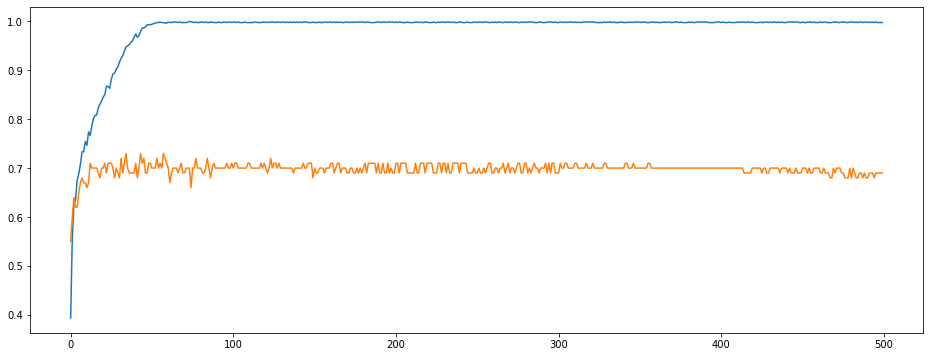

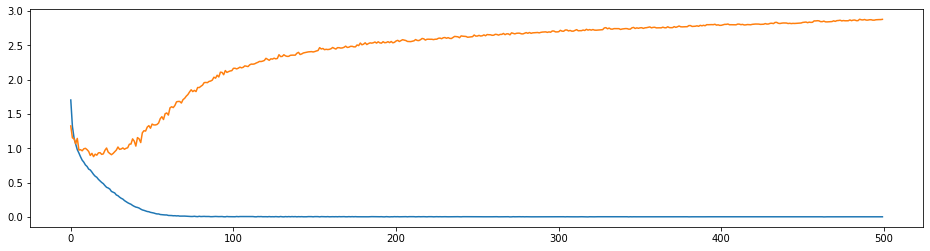

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(historySE.history['accuracy'])
plt.plot(historySE.history['val_accuracy'])
plt.show()
plt.figure(figsize=(16,4))
plt.plot(historySE.history['loss'])
plt.plot(historySE.history['val_loss'])
plt.show()

# слои Dropout в предыдущую сеть

In [ ]:
modelSD = Sequential()
modelSD.add(Dense(1024, activation='elu', input_shape = (len(indexes),)))
modelSD.add(Dropout(0.2))

modelSD.add(Dense(512, activation='elu'))
modelSD.add(Dropout(0.2))

modelSD.add(Dense(256, activation='elu'))
modelSD.add(Dropout(0.2))

modelSD.add(Dense(128, activation='elu'))
modelSD.add(Dropout(0.2))

modelSD.add(Dense(64, activation='elu'))
modelSD.add(Dropout(0.2))

modelSD.add(Dense(128, activation='linear'))
modelSD.add(Dense(10, activation='softmax'))

In [ ]:
modelSD.compile(optimizer=Adadelta(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelSD.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1024)              38912     
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 128)              

In [ ]:
historySD = modelSD.fit(X_train[:, indexes], y_train, epochs=500, batch_size=20, validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
45/45 [==============================] - 1s 8ms/step - loss: 1.9585 - accuracy: 0.2744 - val_loss: 1.3804 - val_accuracy: 0.5200
Epoch 2/500
45/45 [==============================] - 0s 4ms/step - loss: 1.6057 - accuracy: 0.4356 - val_loss: 1.2750 - val_accuracy: 0.5400
Epoch 3/500
45/45 [==============================] - 0s 4ms/step - loss: 1.4314 - accuracy: 0.5167 - val_loss: 1.2324 - val_accuracy: 0.5800
Epoch 4/500
45/45 [==============================] - 0s 4ms/step - loss: 1.3559 - accuracy: 0.5189 - val_loss: 1.1517 - val_accuracy: 0.6300
Epoch 5/500
45/45 [==============================] - 0s 4ms/step - loss: 1.2833 - accuracy: 0.5400 - val_loss: 1.0714 - val_accuracy: 0.6200
Epoch 6/500
45/45 [==============================] - 0s 4ms/step - loss: 1.2376 - accuracy: 0.5756 - val_loss: 1.0638 - val_accuracy: 0.6400
Epoch 7/500
45/45 [==============================] - 0s 4ms/step - loss: 1.2084 - accuracy: 0.5933 - val_loss: 1.0434 - val_accuracy: 0.6300
Epoch 8/500
4

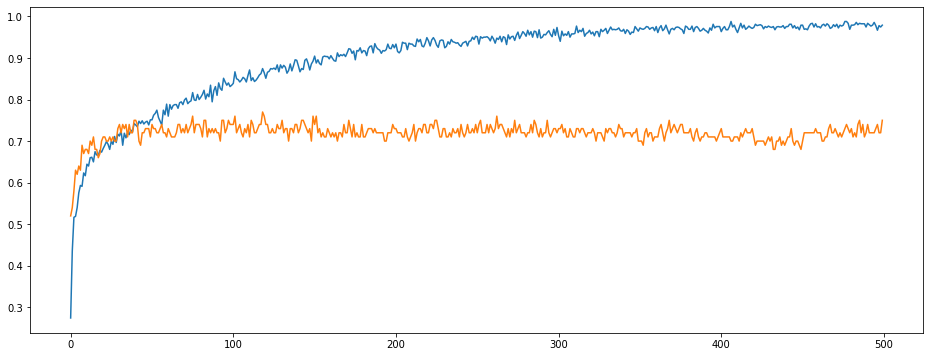

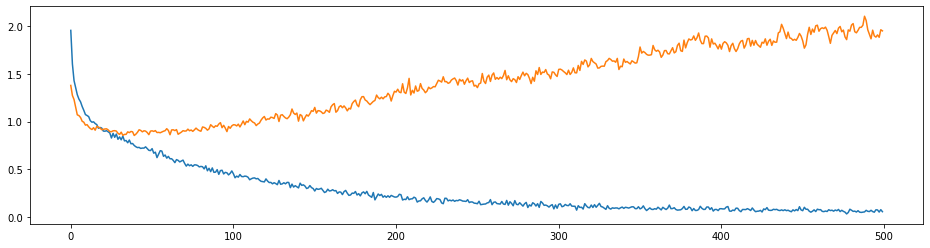

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(historySD.history['accuracy'])
plt.plot(historySD.history['val_accuracy'])
plt.show()
plt.figure(figsize=(16,4))
plt.plot(historySD.history['loss'])
plt.plot(historySD.history['val_loss'])
plt.show()

#  слои BatchNormalization.

In [ ]:
modelSB = Sequential()
modelSB.add(Dense(1024, activation='elu', input_shape = (len(indexes),)))
modelSB.add(Dropout(0.2))
modelSB.add(BatchNormalization())

modelSB.add(Dense(512, activation='elu'))
modelSB.add(Dropout(0.2))
modelSB.add(BatchNormalization())

modelSB.add(Dense(256, activation='elu'))
modelSB.add(Dropout(0.2))
modelSB.add(BatchNormalization())

modelSB.add(Dense(128, activation='elu'))
modelSB.add(Dropout(0.2))
modelSB.add(BatchNormalization())

modelSB.add(Dense(64, activation='elu'))
modelSB.add(Dropout(0.2))
modelSB.add(BatchNormalization())

modelSB.add(Dense(128, activation='linear'))
modelSB.add(Dense(10, activation='softmax'))

In [ ]:
modelSB.compile(optimizer=Adadelta(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelSB.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 1024)              38912     
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_38 (Dense)            (None, 512)               524800    
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [ ]:
historySB = modelSB.fit(X_train[:, indexes], y_train, epochs=500, batch_size=20, validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
45/45 [==============================] - 2s 12ms/step - loss: 0.0660 - accuracy: 0.9733 - val_loss: 1.2479 - val_accuracy: 0.7300
Epoch 2/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0813 - accuracy: 0.9711 - val_loss: 1.2699 - val_accuracy: 0.7100
Epoch 3/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0922 - accuracy: 0.9678 - val_loss: 1.1801 - val_accuracy: 0.7600
Epoch 4/500
45/45 [==============================] - 0s 6ms/step - loss: 0.1060 - accuracy: 0.9611 - val_loss: 1.1377 - val_accuracy: 0.7600
Epoch 5/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0821 - accuracy: 0.9667 - val_loss: 1.1333 - val_accuracy: 0.7500
Epoch 6/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0874 - accuracy: 0.9711 - val_loss: 1.2017 - val_accuracy: 0.7300
Epoch 7/500
45/45 [==============================] - 0s 6ms/step - loss: 0.1005 - accuracy: 0.9656 - val_loss: 1.1835 - val_accuracy: 0.7300
Epoch 8/500


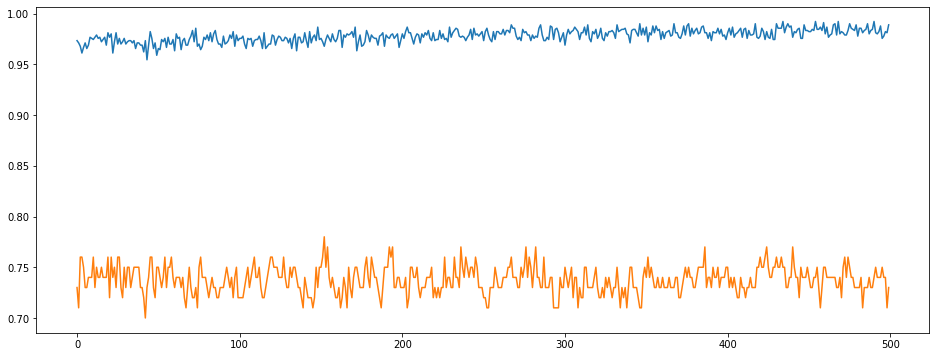

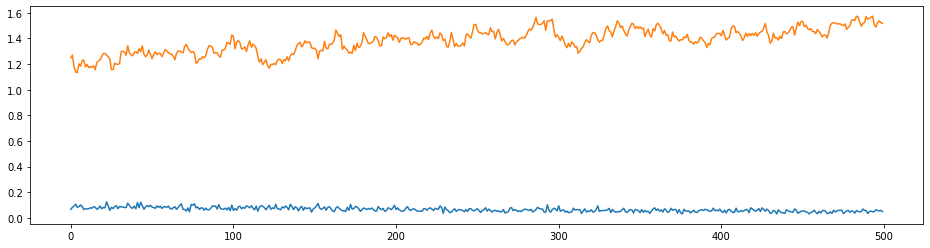

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(historySB.history['accuracy'])
plt.plot(historySB.history['val_accuracy'])
plt.show()
plt.figure(figsize=(16,4))
plt.plot(historySB.history['loss'])
plt.plot(historySB.history['val_loss'])
plt.show()

# внутренние активационные функции, варианты: relu, elu, linear.



---
поменяю первые слои на Linear.  Так делал в задание Ультра Лайт, там неплохо вышло:


In [ ]:
modelSS = Sequential()
modelSS.add(Dense(1024, activation='linear', input_shape = (len(indexes),)))
modelSS.add(Dropout(0.2))
modelSS.add(BatchNormalization())

modelSS.add(Dense(512, activation='linear'))
modelSS.add(Dropout(0.2))
modelSS.add(BatchNormalization())

modelSS.add(Dense(256, activation='linear'))
modelSS.add(Dropout(0.2))
modelSS.add(BatchNormalization())

modelSS.add(Dense(128, activation='linear'))
modelSS.add(Dropout(0.2))
modelSS.add(BatchNormalization())

modelSS.add(Dense(64, activation='linear'))
modelSS.add(Dropout(0.2))
modelSS.add(BatchNormalization())

modelSS.add(Dense(128, activation='elu'))
modelSS.add(Dense(10, activation='softmax'))

In [ ]:
modelSS.compile(optimizer=Adadelta(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelSS.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 1024)              38912     
                                                                 
 dropout_25 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_10 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_45 (Dense)            (None, 512)               524800    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                     

In [ ]:
historySS = modelSS.fit(X_train[:, indexes], y_train, epochs=500, batch_size=20, validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
45/45 [==============================] - 2s 11ms/step - loss: 1.9828 - accuracy: 0.2967 - val_loss: 1.5051 - val_accuracy: 0.5100
Epoch 2/500
45/45 [==============================] - 0s 6ms/step - loss: 1.6627 - accuracy: 0.4056 - val_loss: 1.4061 - val_accuracy: 0.4900
Epoch 3/500
45/45 [==============================] - 0s 6ms/step - loss: 1.5584 - accuracy: 0.4633 - val_loss: 1.3641 - val_accuracy: 0.5600
Epoch 4/500
45/45 [==============================] - 0s 6ms/step - loss: 1.4648 - accuracy: 0.5000 - val_loss: 1.3077 - val_accuracy: 0.5700
Epoch 5/500
45/45 [==============================] - 0s 6ms/step - loss: 1.4328 - accuracy: 0.5311 - val_loss: 1.2645 - val_accuracy: 0.5600
Epoch 6/500
45/45 [==============================] - 0s 6ms/step - loss: 1.4180 - accuracy: 0.5189 - val_loss: 1.2058 - val_accuracy: 0.5900
Epoch 7/500
45/45 [==============================] - 0s 6ms/step - loss: 1.3627 - accuracy: 0.5422 - val_loss: 1.1825 - val_accuracy: 0.6000
Epoch 8/500


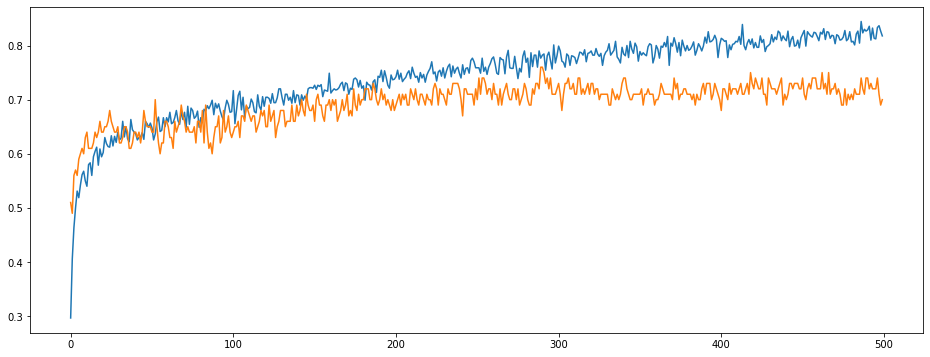

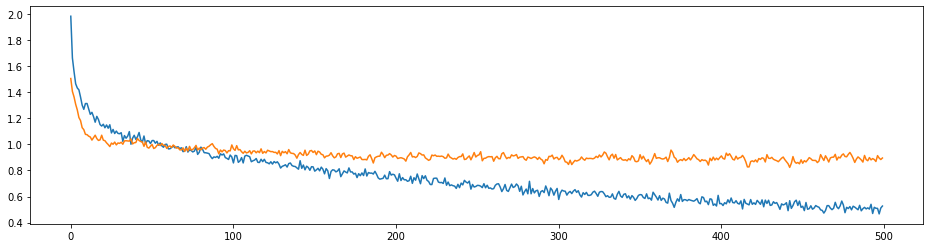

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(historySS.history['accuracy'])
plt.plot(historySS.history['val_accuracy'])
plt.show()
plt.figure(figsize=(16,4))
plt.plot(historySS.history['loss'])
plt.plot(historySS.history['val_loss'])
plt.show()

# batch_size: маленький, средний и большой.

был batch_size=20, как бы он между средним и маленьким. Буду использовать средний =50, и большой =100

In [ ]:
history_50 = modelSS.fit(X_train[:, indexes], y_train, epochs=500, batch_size=50, validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
18/18 [==============================] - 1s 23ms/step - loss: 0.4824 - accuracy: 0.8367 - val_loss: 0.8872 - val_accuracy: 0.7100
Epoch 2/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4647 - accuracy: 0.8444 - val_loss: 0.8869 - val_accuracy: 0.7300
Epoch 3/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4563 - accuracy: 0.8500 - val_loss: 0.8851 - val_accuracy: 0.7200
Epoch 4/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4880 - accuracy: 0.8311 - val_loss: 0.8841 - val_accuracy: 0.7100
Epoch 5/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4998 - accuracy: 0.8289 - val_loss: 0.8905 - val_accuracy: 0.7200
Epoch 6/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4660 - accuracy: 0.8389 - val_loss: 0.8956 - val_accuracy: 0.7300
Epoch 7/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4704 - accuracy: 0.8356 - val_loss: 0.8953 - val_accuracy: 0.7200
Epoch 8/500




---
строить график не буду, т.к значения практически не поменялись.

теперь с большим =100


In [ ]:
history_100 = modelSS.fit(X_train[:, indexes], y_train, epochs=500, batch_size=100, validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
9/9 [==============================] - 0s 13ms/step - loss: 0.2027 - accuracy: 0.9356 - val_loss: 0.9729 - val_accuracy: 0.7500
Epoch 2/500
9/9 [==============================] - 0s 10ms/step - loss: 0.2491 - accuracy: 0.9178 - val_loss: 0.9803 - val_accuracy: 0.7300
Epoch 3/500
9/9 [==============================] - 0s 10ms/step - loss: 0.2179 - accuracy: 0.9389 - val_loss: 0.9904 - val_accuracy: 0.7300
Epoch 4/500
9/9 [==============================] - 0s 10ms/step - loss: 0.2469 - accuracy: 0.9111 - val_loss: 0.9878 - val_accuracy: 0.7500
Epoch 5/500
9/9 [==============================] - 0s 10ms/step - loss: 0.2499 - accuracy: 0.9100 - val_loss: 0.9965 - val_accuracy: 0.7200
Epoch 6/500
9/9 [==============================] - 0s 10ms/step - loss: 0.2424 - accuracy: 0.9189 - val_loss: 1.0058 - val_accuracy: 0.7200
Epoch 7/500
9/9 [==============================] - 0s 10ms/step - loss: 0.2213 - accuracy: 0.9322 - val_loss: 0.9957 - val_accuracy: 0.7300
Epoch 8/500
9/9 [===

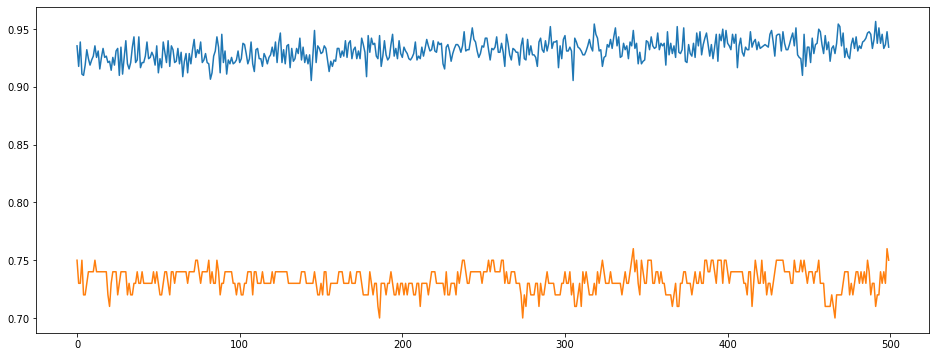

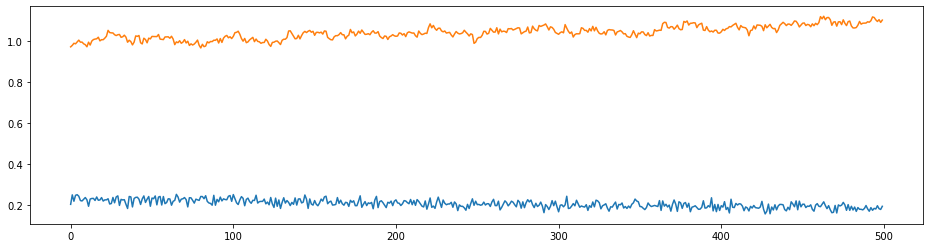

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(history_100.history['accuracy'])
plt.plot(history_100.history['val_accuracy'])
plt.show()
plt.figure(figsize=(16,4))
plt.plot(history_100.history['loss'])
plt.plot(history_100.history['val_loss'])
plt.show()

# Архетектуры

In [ ]:
from tensorflow.keras.utils import plot_model

1. простая модель 

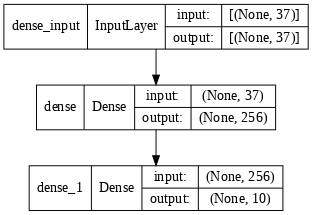

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

2. сложная сеть 

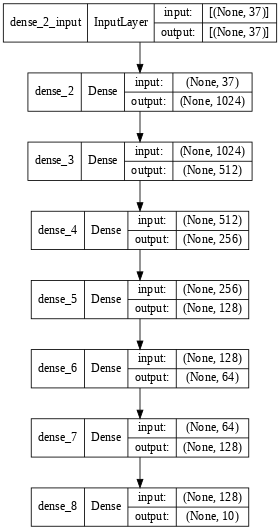

In [ ]:
plot_model(modelSE, show_shapes=True, dpi=60)

3. with Dropout:

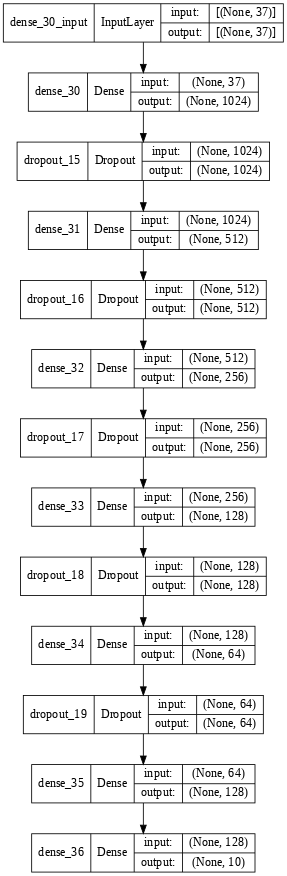

In [ ]:
plot_model(modelSD, show_shapes=True, dpi=60)

with BatchNormalization:

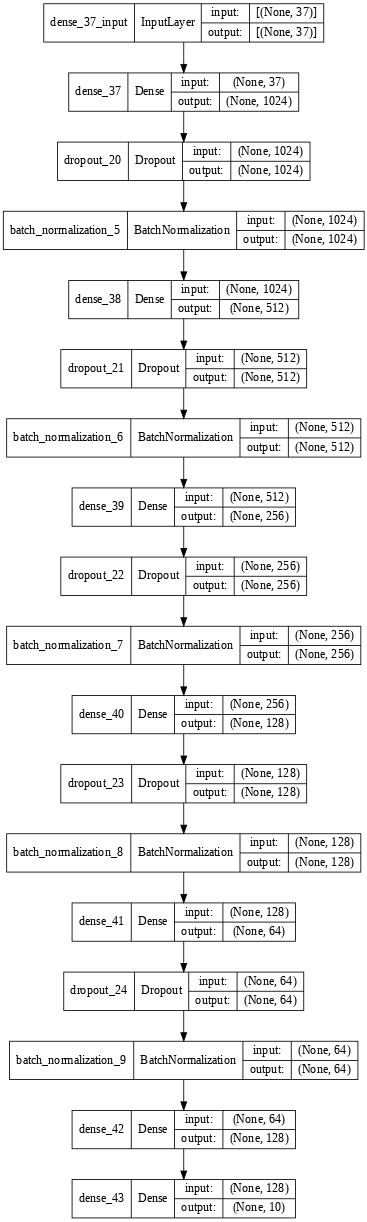

In [ ]:
plot_model(modelSB, show_shapes=True, dpi=60)

# Выводы:

In [ ]:
import pandas as pd

In [ ]:
from operator import index
columns = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
index = ['простая сеть', 'сложная сеть', 'с Dropout', 'с BatchNormalization', 'замена elu/linear', 'midlle batch50', 'large batch100']
data = ([[0.3645, 0.8944, 0.8526, 0.68], [0.0036, 0.9978, 2.8792, 0.69],
         [0.0549, 0.9789, 1.9535, 0.75],[0.0888, 0.9889, 1.5176, 0.73],
         [0.5091, 0.8333, 0.9131, 0.74], [0.3254, 0.8833, 0.926, 0.73], [0.1931, 0.4344, 1.1038, 0.75]])

In [ ]:
df = pd.DataFrame(data, columns=columns, index=index)

In [ ]:
df

,loss,accuracy,val_loss,val_accuracy
простая сеть,0.3645,0.8944,0.8526,0.68
сложная сеть,0.0036,0.9978,2.8792,0.69
с Dropout,0.0549,0.9789,1.9535,0.75
с BatchNormalization,0.0888,0.9889,1.5176,0.73
замена elu/linear,0.5091,0.8333,0.9131,0.74
midlle batch50,0.3254,0.8833,0.9260,0.73
large batch100,0.1931,0.4344,1.1038,0.75


**ВЫВОД:** При простом прогоне задания подметил, что простая сеть и сложная по показателям мало изменяется с разницей лишь: сложная НС заучила полностью и больше движухи не предвидиться , а простая можно увеличить на входе нейронов результат может и обойдёт сложную. Результат всё равно остаётся на среднем уровне. С добавлением Dropout после каждого срытого слоя видно улучшение результатов НС, но всё равно идёт переобучение. Можно на этом этапе варьировать величиной отсечения. На ультра лайт хорошо повела себя сеть при значении 0,6.

При добавлении слоя BatchNormalizatoin показатели стали более стабильные и снизилась ошибка на проверочной выборке, что как мне кажется говорит о том, что данные слои имеют место в этой НС, хоть и показатели мало отличаются со слоями Дроп. Полная замена местами linеar на elu, как и в задании ультра лайт также показали себя с хорошей стороны. Думается, что сквозной проход здесь более уместен на первых слоях, но необходимость преобразовать их в elu ( с мешочком около нулевых значений) на последнем слое. При увеличении Батча тут не однозначно. Скорее надо исследовать на более большом количестве эпох. 

При компиляции модели использовал оптимизатор Adadelta. Как показали наблюдения, этот оптимизатор легко справляется с перескакиванием локальных минимумов (так мне думается, может не прав). Тут главное, поймать шаг обучения. Его уменьшение не обязательно приводит к лучшему результату. Начинал с lr=1.0.
Вот, как то так! 